https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

## One-Step univariate time series forecast

## based on LSTM_Baseline.ipynb !!

# TODO: use ERA5 data to regulate loss function

In [1]:
# univariate data preparation
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import pandas as pd
import numpy as np
import tensorflow as tf
import myLibrary as mL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import netCDF4 as nc
import matplotlib.pyplot as plt

In [2]:
STATION_ID = "42036"    # 33.61% NaN values -> Best value for GOM and 2022
YEAR = "2022"
n=1
lag=1
n_test_hours = 7*24

## Get NDBC Data

In [3]:
data_NDBC = mL.get_buoy_data(STATION_ID, YEAR)

data_NDBC = data_NDBC.drop([
    "WDIR_42036",
    "WSPD_42036",
    "WVHT_42036",
    "APD_42036",
    "MWD_42036",
    "PRES_42036",
    "ATMP_42036",
    #"WTMP_42036",
    "DEWP_42036"], axis=1)

from disc


In [4]:
print("NaN values: ", data_NDBC.isna().sum().sum())
data_NDBC.fillna(method='ffill', inplace=True) #ffill .. forward fill (just copy previous value)
print("Remaining NaN values: ", data_NDBC.isna().sum().sum())
# msno.matrix(data)

NaN values:  57
Remaining NaN values:  0


In [5]:
data_NDBC

,WTMP_42036
timestamp,
2022-01-01 00:00:00,23.0
2022-01-01 01:00:00,23.0
2022-01-01 02:00:00,23.0
2022-01-01 03:00:00,23.0
2022-01-01 04:00:00,23.0
...,...
2022-12-31 19:00:00,22.0
2022-12-31 20:00:00,22.0
2022-12-31 21:00:00,22.1


# Get ERA5 data

In [6]:
# Only required once to download it
# mL.download_ERA5_singlePoint(STATION_ID, YEAR, variables=['sea_surface_temperature'])

#TODO: right now I am overwriting the data with only one feature! To use the library properly, I need to clean this up and improve the reusability, --> First figure out how I really want to save the data!

In [7]:
data_ERA5 = nc.Dataset(f'../data/ERA5_downloads/singleStations/{STATION_ID}_{YEAR}.nc')
data_ERA5

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-04-18 01:59:39 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data5/adaptor.mars.internal-1681783149.5535574-25820-15-72cd7e50-62e4-4284-b468-417a29faca6e.nc /cache/tmp/72cd7e50-62e4-4284-b468-417a29faca6e-adaptor.mars.internal-1681782749.1788428-25820-24-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), time(8760)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 sst(time, latitude, longitude)
    groups: 

In [8]:
data_ERA5 = nc.Dataset(f'../data/ERA5_downloads/singleStations/{STATION_ID}_{YEAR}.nc')
sst = data_ERA5.variables["sst"][:, :, 0].data

data_ERA5 = pd.DataFrame({
    f'WTMP_{STATION_ID}_ERA5': sst[:,0],     # SST
    })

data_ERA5[f"WTMP_{STATION_ID}_ERA5"] -= 273.15

data_ERA5["timestamp"] = mL.create_timestamp_list2(YEAR)
data_ERA5.set_index('timestamp', inplace = True)

data_ERA5

,WTMP_42036_ERA5
timestamp,
2022-01-01 00:00:00,22.942808
2022-01-01 01:00:00,22.942808
2022-01-01 02:00:00,22.942808
2022-01-01 03:00:00,22.942808
2022-01-01 04:00:00,22.942808
...,...
2022-12-31 19:00:00,21.524296
2022-12-31 20:00:00,21.524296
2022-12-31 21:00:00,21.524296


# Preprocessing

### Merge Dataframes

In [9]:
data = pd.merge(data_NDBC, data_ERA5, left_index=True, right_index=True)
data = data.rename(columns={'WTMP_42036': 'WTMP_NDBC', 'WTMP_42036_ERA5': 'WTMP_ERA5'})
data

,WTMP_NDBC,WTMP_ERA5
timestamp,,
2022-01-01 00:00:00,23.0,22.942808
2022-01-01 01:00:00,23.0,22.942808
2022-01-01 02:00:00,23.0,22.942808
2022-01-01 03:00:00,23.0,22.942808
2022-01-01 04:00:00,23.0,22.942808
...,...,...
2022-12-31 19:00:00,22.0,21.524296
2022-12-31 20:00:00,22.0,21.524296
2022-12-31 21:00:00,22.1,21.524296


<AxesSubplot:xlabel='timestamp'>

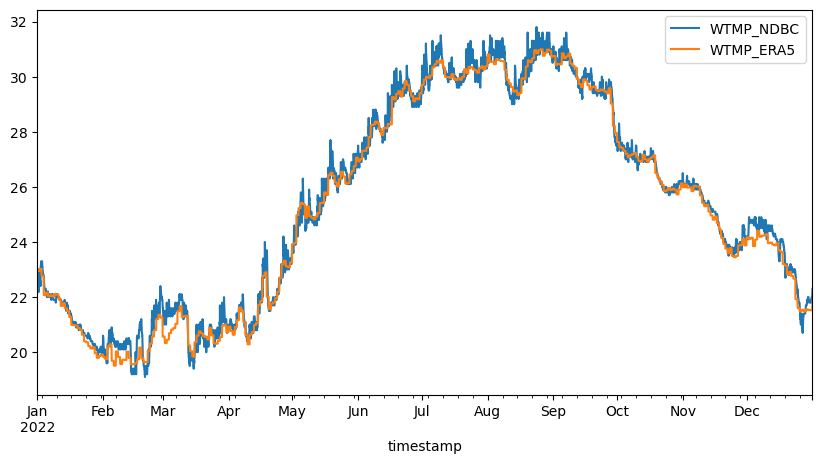

In [10]:
data.plot( figsize=(10, 5))

-----
# Transform Time Series to Stationary (NOT MENDATORY!!)

.. anyways I think this function works fine!

In [46]:
def data_to_stationary(data):
    data_stationary = pd.DataFrame()

    for col in data.columns:
        data_stationary[col] = data[col] - data[col].shift(n)  # y = value(i) - value(i-n)

    data_stationary = data_stationary.iloc[n:]  # remove first n entries since there is no delta value for them
    return data_stationary

data_stationary = data_to_stationary(data)
data_stationary

,WTMP_NDBC,WTMP_ERA5
timestamp,,
2022-01-01 01:00:00,0.0,0.000000
2022-01-01 02:00:00,0.0,0.000000
2022-01-01 03:00:00,0.0,0.000000
2022-01-01 04:00:00,0.0,0.000000
2022-01-01 05:00:00,0.0,0.000000
...,...,...
2022-12-31 19:00:00,0.0,0.000000
2022-12-31 20:00:00,0.0,0.000000
2022-12-31 21:00:00,0.1,0.000000


<AxesSubplot:xlabel='timestamp'>

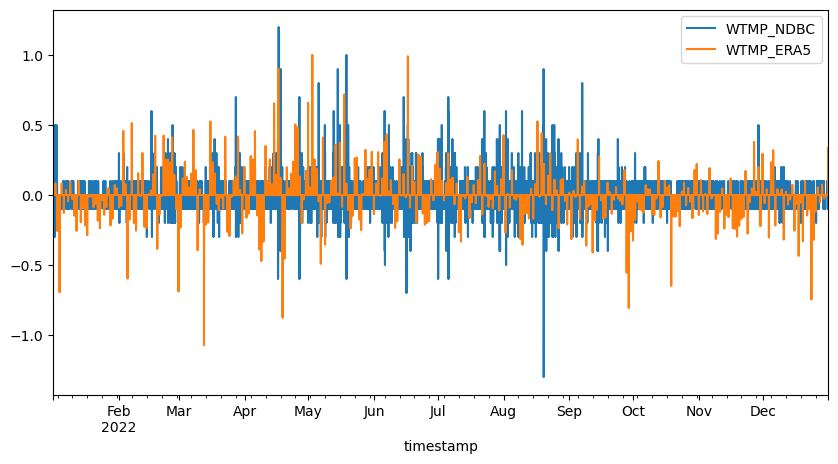

In [47]:
data_stationary.plot( figsize=(10, 5))

----
# Transform to supervised problem

In [48]:
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def data_to_supervised(data, n_in=1, n_out=1, dropnan=True):
     """
     Frame a time series as a supervised learning dataset.
     Arguments:
     data: Sequence of observations as a list or NumPy array.
     n_in: Number of lag observations as input (X).
     n_out: Number of observations as output (y).
     dropnan: Boolean whether or not to drop rows with NaN values.
     Returns:
     Pandas DataFrame of series framed for supervised learning.
     """
     n_vars = data.shape[1]
     col_names = data.columns

     cols, names = list(), list()
     # input sequence (t-n, ... t-1)
     for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)

     for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values

     if dropnan:
        agg.dropna(inplace=True)
     return agg

In [49]:
# data_supervised = data_to_supervised(data_stationary)
data_supervised = data_to_supervised(data_stationary)
data_supervised

,WTMP_NDBC(t-1),WTMP_ERA5(t-1),WTMP_NDBC(t),WTMP_ERA5(t)
timestamp,,,,
2022-01-01 02:00:00,0.0,0.000000,0.0,0.000000
2022-01-01 03:00:00,0.0,0.000000,0.0,0.000000
2022-01-01 04:00:00,0.0,0.000000,0.0,0.000000
2022-01-01 05:00:00,0.0,0.000000,0.0,0.000000
2022-01-01 06:00:00,0.0,0.000000,-0.1,0.000000
...,...,...,...,...
2022-12-31 19:00:00,0.1,0.000000,0.0,0.000000
2022-12-31 20:00:00,0.0,0.000000,0.0,0.000000
2022-12-31 21:00:00,0.0,0.000000,0.1,0.000000


-----
# train test split

In [50]:
def train_test_split(data, n_test_hours):
    # split into train and test sets
    values = data.values
    train = values[n_test_hours:, :]
    test = values[:n_test_hours, :]

    # get indices of input and output columns
    input_cols = [i for i in range(values.shape[1]) if 't-' in data.columns[i]]
    output_cols = [i for i in range(values.shape[1]) if ('(t)' in data.columns[i]) or ('t+' in data.columns[i])]

    # split into input and outputs
    train_X, train_y = train[:, input_cols], train[:, output_cols]
    test_X, test_y = test[:, input_cols], test[:, output_cols]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = train_test_split(data_supervised, n_test_hours)
print("Shapes: ", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Shapes:  (8590, 1, 2) (8590, 2) (168, 1, 2) (168, 2)


In [56]:
train_X

array([[[ 0.        ,  0.        ]],

       [[-0.1       ,  0.        ]],

       [[ 0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ]],

       [[ 0.1       ,  0.        ]],

       [[ 0.1       ,  0.33811631]]])

In [57]:
train_y

array([[-0.1       ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [ 0.1       ,  0.        ],
       [ 0.1       ,  0.33811631],
       [ 0.1       ,  0.        ]])

In [58]:
test_X

array([[[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[-0.1       ,  0.        ]],

       [[-0.3       ,  0.        ]],

       [[-0.2       ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.1       ,  0.        ]],

       [[-0.2       ,  0.        ]],

       [[-0.1       ,  0.        ]],

       [[ 0.3       ,  0.        ]],

       [[-0.3       ,  0.        ]],

       [[ 0.1       ,  0.        ]],

       [[ 0.1       ,  0.        ]],

       [[ 0.5       ,  0.        ]],

       [[ 0.1       ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[-0.1       ,  0.        ]],

       [[ 0.        ,  0.08374072]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[-0.1       ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[-0.

In [59]:
test_y

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.1       ,  0.        ],
       [-0.3       ,  0.        ],
       [-0.2       ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.1       ,  0.        ],
       [-0.2       ,  0.        ],
       [-0.1       ,  0.        ],
       [ 0.3       ,  0.        ],
       [-0.3       ,  0.        ],
       [ 0.1       ,  0.        ],
       [ 0.1       ,  0.        ],
       [ 0.5       ,  0.        ],
       [ 0.1       ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.1       ,  0.        ],
       [ 0.        ,  0.08374072],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.1       ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.1       ,  0.        ],
       [-0.1       ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

----
# Normalize the data (Not mendatory step)
# This function does not work perfectly, bad code-reusability - needs to be improved!

In [20]:
# scaler = None
# def scale(train, test):
#     # fit scaler
#     global scaler
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     train_col = train["X"].values.reshape(-1, 1)
#     scaler = scaler.fit(train_col)
#
#     # transform train
#     train_scaled = pd.DataFrame()
#     train_scaled["X"] = pd.Series(scaler.transform(train[["X"]]).squeeze())
#     train_scaled["y_NDBC"] = pd.Series(scaler.transform(train[["y_NDBC"]]).squeeze())
#     train_scaled["y_ERA5"] = pd.Series(scaler.transform(train[["y_ERA5"]]).squeeze())
#
#     # transform test
#     test_scaled = pd.DataFrame()
#     test_scaled["X"] = pd.Series(scaler.transform(test[["X"]]).squeeze())
#     test_scaled["y_NDBC"] = pd.Series(scaler.transform(test[["y_NDBC"]]).squeeze())
#     test_scaled["y_ERA5"] = pd.Series(scaler.transform(test[["y_ERA5"]]).squeeze())
#
#     return train_scaled, test_scaled
#
# #invert single float value
# def invert_scale(value):
#     scaled_value_array = np.array([[value, 0]])
#     inverted_value = scaler.inverse_transform(scaled_value_array)[0][0]
#     return inverted_value

In [21]:
# train_scaled, test_scaled = scale(train, test)

In [22]:
# train_scaled

In [23]:
# test_scaled

In [24]:
#Convert to numpy.ndarray
# X_train = train_scaled['X'].values
# y_train = train_scaled[['y_NDBC', 'y_ERA5']].values #0... y_NDBC, 1... y_ERA5
#
# X_test = test_scaled['X'].values
# y_test = test_scaled[['y_NDBC', 'y_ERA5']].values #0... y_NDBC, 1... y_ERA5

----
Just dev purpose:
## LSTM model (no PINN)

In [60]:
# fit an LSTM network to training data
def fit_lstm(train_X, train_y):

    #design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(train_X.shape[2])) # Predict all features!
    model.compile(loss='mean_squared_error', optimizer='adam')   #SGD instead of adam ... SGD is a more simple optimizer which can help avoiding overfitting

    # fit network
    model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=0, shuffle=False)

    return model

In [61]:
lstm_model = fit_lstm(train_X, train_y)
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10600     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Forecast the entire training dataset to build up state for forecasting
def build_up_state(model):
    #Reset state
    model.reset_states()
    # forecast the entire training dataset to build up state for forecasting
    model.predict(train_X, batch_size=1)

# One-Shot Forecasting

In [63]:
build_up_state(lstm_model)

8590/8590 [==============================] - 3s 320us/step


In [64]:
output_cols = data_supervised.filter(regex='\(t[\+]*\)').columns.tolist()
prediction_1 = pd.DataFrame(test_y, columns=output_cols)

yhat = lstm_model.predict(test_X)
yhat = pd.DataFrame(yhat, columns=[name + "_pred" for name in output_cols])

prediction_1 = pd.concat([prediction_1, yhat], axis=1)
prediction_1

6/6 [==============================] - 0s 599us/step


,WTMP_NDBC(t),WTMP_ERA5(t),WTMP_NDBC(t)_pred,WTMP_ERA5(t)_pred
0,0.0,0.000000,0.000104,-0.002454
1,0.0,0.000000,0.000104,-0.002454
2,0.0,0.000000,0.000104,-0.002454
3,0.0,0.000000,0.000104,-0.002454
4,-0.1,0.000000,0.000104,-0.002454
...,...,...,...,...
163,0.0,0.000000,0.000222,-0.000114
164,0.0,-0.043797,0.000104,-0.002454
165,-0.1,0.000000,-0.002035,-0.002295
166,0.1,0.000000,-0.006640,-0.003972


<AxesSubplot:>

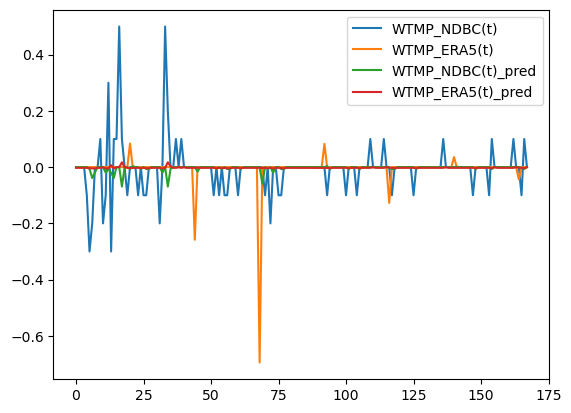

In [65]:
prediction_1.plot(kind='line')

In [78]:
# report performance
mae = mean_absolute_error(prediction_1["WTMP_NDBC(t)"], prediction_1["WTMP_NDBC(t)_pred"])
mse = mean_squared_error(prediction_1["WTMP_NDBC(t)"], prediction_1["WTMP_NDBC(t)_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.03954818066655824
MSE:  0.008003578963509415


# 2-Week forecast

In [66]:
build_up_state(lstm_model)

8590/8590 [==============================] - 3s 321us/step


In [67]:
# make a one-step forecast
# This function helps with reshaping.
def single_forecast(model, x):
    x = x.reshape(1, 1, len(x[0]))
    yhat = model.predict(x, verbose=0)
    return yhat

In [68]:
prediction_2 = pd.DataFrame(test_y, columns=output_cols)
for col in output_cols:
    prediction_2[f"{col}_pred"] = 0
prediction_2

,WTMP_NDBC(t),WTMP_ERA5(t),WTMP_NDBC(t)_pred,WTMP_ERA5(t)_pred
0,0.0,0.000000,0,0
1,0.0,0.000000,0,0
2,0.0,0.000000,0,0
3,0.0,0.000000,0,0
4,-0.1,0.000000,0,0
...,...,...,...,...
163,0.0,0.000000,0,0
164,0.0,-0.043797,0,0
165,-0.1,0.000000,0,0
166,0.1,0.000000,0,0


In [69]:
prev_obs = test_X[0]
for i, row in prediction_2.iterrows():
    yhat = single_forecast(lstm_model, prev_obs)

    #Mapping of array index and df column name
    for j, element in enumerate(output_cols):
        prediction_2.at[i, f"{element}_pred"] =yhat[0,j]

prediction_2

,WTMP_NDBC(t),WTMP_ERA5(t),WTMP_NDBC(t)_pred,WTMP_ERA5(t)_pred
0,0.0,0.000000,0.000104,-0.002454
1,0.0,0.000000,0.000104,-0.002454
2,0.0,0.000000,0.000104,-0.002454
3,0.0,0.000000,0.000104,-0.002454
4,-0.1,0.000000,0.000104,-0.002454
...,...,...,...,...
163,0.0,0.000000,0.000104,-0.002454
164,0.0,-0.043797,0.000104,-0.002454
165,-0.1,0.000000,0.000104,-0.002454
166,0.1,0.000000,0.000104,-0.002454


<AxesSubplot:>

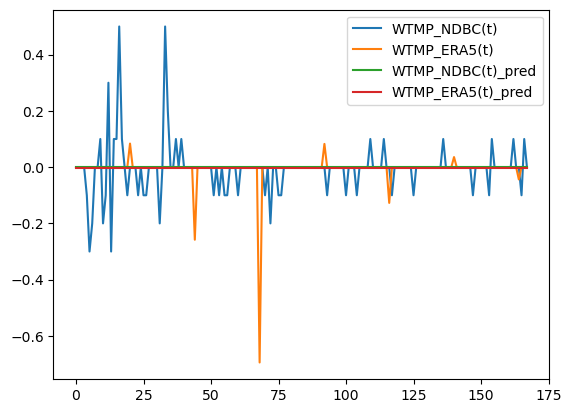

In [70]:
prediction_2.plot(kind='line')

In [79]:
# report performance
mae = mean_absolute_error(prediction_2["WTMP_NDBC(t)"], prediction_2["WTMP_NDBC(t)_pred"])
mse = mean_squared_error(prediction_2["WTMP_NDBC(t)"], prediction_2["WTMP_NDBC(t)_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.03758455403925241
MSE:  0.007798749054813432


----

# REAL PINN STUFF

In [107]:
ALPHA = 1

In [108]:
from keras import backend as K

def custom_loss(alpha):
    def loss(y_true, y_pred):
        # Split y_true and y_pred into two features
        y_true_f1, y_true_f2 = tf.split(y_true, num_or_size_splits=2, axis=1)
        y_pred_f1, y_pred_f2 = tf.split(y_pred, num_or_size_splits=2, axis=1)

        # Calculate the mean squared error for each feature
        mse_f1 = K.mean(K.square(y_true_f1 - y_pred_f1), axis=-1)
        mse_f2 = K.mean(K.square(y_true_f2 - y_pred_f2), axis=-1)

        # Calculate the weighted loss
        weighted_loss = alpha * mse_f1 + (1-alpha) * mse_f2

        return weighted_loss

    return loss

In [109]:
def fit_pinn(train_X, train_y):

    #design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(train_X.shape[2])) # Predict all features!

    model.compile(optimizer='adam',
                  loss=custom_loss(alpha=ALPHA),
                  #loss='mean_squared_error',
                  )

    # fit network
    model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=0, shuffle=False)

    return model

In [110]:
pinn_model = fit_pinn(train_X, train_y)
pinn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10600     
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________


In [111]:
build_up_state(pinn_model)

8590/8590 [==============================] - 3s 323us/step


In [112]:
output_cols = data_supervised.filter(regex='\(t[\+]*\)').columns.tolist()
prediction_3 = pd.DataFrame(test_y, columns=output_cols)

yhat = pinn_model.predict(test_X)
yhat = pd.DataFrame(yhat, columns=[name + "_pred" for name in output_cols])

prediction_3 = pd.concat([prediction_3, yhat], axis=1)
prediction_3

6/6 [==============================] - 0s 632us/step


,WTMP_NDBC(t),WTMP_ERA5(t),WTMP_NDBC(t)_pred,WTMP_ERA5(t)_pred
0,0.0,0.000000,0.000328,0.000239
1,0.0,0.000000,0.000328,0.000239
2,0.0,0.000000,0.000328,0.000239
3,0.0,0.000000,0.000328,0.000239
4,-0.1,0.000000,0.000328,0.000239
...,...,...,...,...
163,0.0,0.000000,-0.000084,-0.002446
164,0.0,-0.043797,0.000328,0.000239
165,-0.1,0.000000,-0.001760,-0.000103
166,0.1,0.000000,-0.005788,0.003761


In [113]:
# report performance
mae = mean_absolute_error(prediction_3["WTMP_NDBC(t)"], prediction_3["WTMP_NDBC(t)_pred"])
mse = mean_squared_error(prediction_3["WTMP_NDBC(t)"], prediction_3["WTMP_NDBC(t)_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.03960204923877481
MSE:  0.008011802279363364


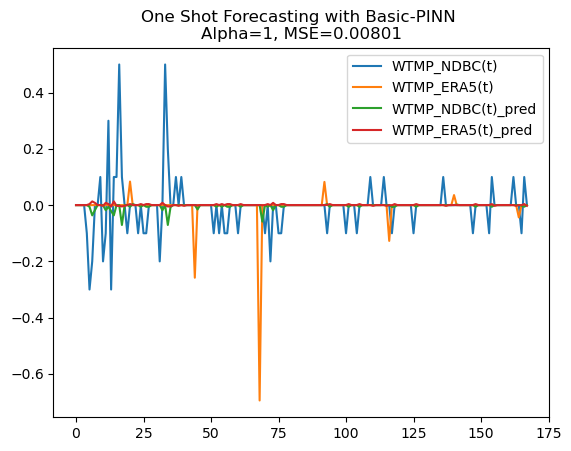

In [114]:
prediction_3.plot(kind='line')
plt.title(f'One Shot Forecasting with Basic-PINN \nAlpha={ALPHA}, MSE={mse.round(5)}')
plt.show()